In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# tỉ lệ 8:2
df = pd.read_csv('F:/hk2 nam3/nhi/is403/IS403_O21_04/Dataset/DXG Historical Data 1_6.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df[::-1]

df = df.reset_index(drop=True) # Reset the index

In [3]:
# Split the data into training, testing, and validation sets
train_size = int(0.9 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])

In [5]:
final_model = SimpleExpSmoothing(x_train).fit(optimized=True)
y_pred = final_model.forecast(160)

In [6]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = final_model.forecast(len(x_next_30_days))
y_next_30_days

array([1436.99999999, 1436.99999999, 1436.99999999, 1436.99999999,
       1436.99999999, 1436.99999999, 1436.99999999, 1436.99999999,
       1436.99999999, 1436.99999999, 1436.99999999, 1436.99999999,
       1436.99999999, 1436.99999999, 1436.99999999, 1436.99999999,
       1436.99999999, 1436.99999999, 1436.99999999, 1436.99999999,
       1436.99999999, 1436.99999999, 1436.99999999, 1436.99999999,
       1436.99999999, 1436.99999999, 1436.99999999, 1436.99999999,
       1436.99999999, 1436.99999999])

In [7]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 16745.168750014902
RMSE: 16795.059712434755
MAPE: 0.9205459120537984


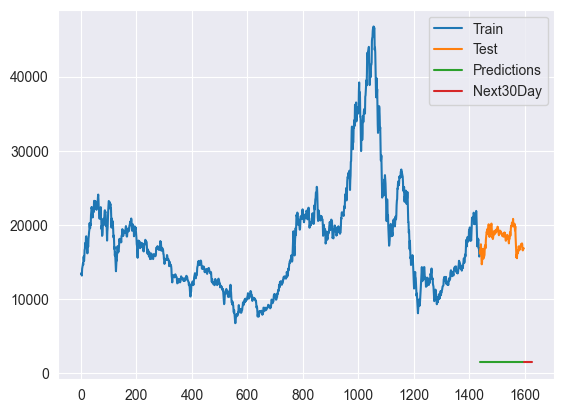

In [8]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [9]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train.plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test.plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

def des_optimizer(train, test, alphas, betas, trend, step):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
best_alpha, best_beta, best_mae = des_optimizer(x_train, x_test, alphas, betas, trend='add', step=160)
final_model = ExponentialSmoothing(x_train, trend='add').fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
y_pred = final_model.forecast(160)

In [10]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = final_model.forecast(len(x_next_30_days))
y_next_30_days

array([1438., 1439., 1440., 1441., 1442., 1443., 1444., 1445., 1446.,
       1447., 1448., 1449., 1450., 1451., 1452., 1453., 1454., 1455.,
       1456., 1457., 1458., 1459., 1460., 1461., 1462., 1463., 1464.,
       1465., 1466., 1467.])

In [11]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 16664.66875
RMSE: 16714.777502071334
MAPE: 0.9161016421243712


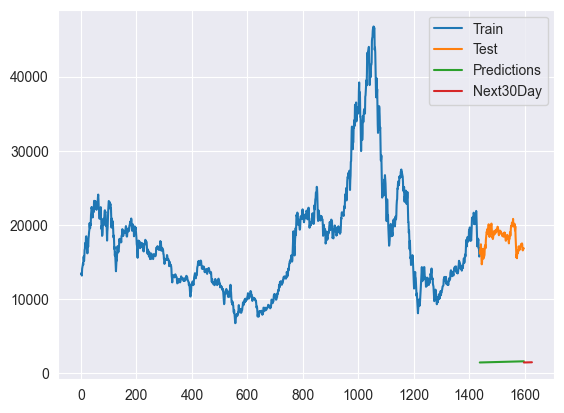

In [12]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [13]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        if np.isnan(y_pred).any():
            continue  # Skip this combination if y_pred contains NaN values
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='add', seasonal_periods=12, step=160)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(160)



In [14]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([ 16932.36493088,  15847.45343734,  14985.54347208,  14204.74685232,
        13944.68220159,  13707.10296023,  13399.98467452,  13135.0702698 ,
        12654.59410065,  12588.1770207 ,  12029.52088887,  12605.47805447,
        11894.38731899,  10809.47582544,   9947.56586019,   9166.76924043,
         8906.70458969,   8669.12534834,   8362.00706263,   8097.09265791,
         7616.61648875,   7550.19940881,   6991.54327698,   7567.50044258,
         6856.4097071 ,   5771.49821355,   4909.5882483 ,   4128.79162854,
         3868.7269778 ,   3631.14773644,   3324.02945074,   3059.11504601,
         2578.63887686,   2512.22179691,   1953.56566508,   2529.52283069,
         1818.43209521,    733.52060166,   -128.38936359,   -909.18598336,
        -1169.25063409,  -1406.82987545,  -1713.94816115,  -1978.86256588,
        -2459.33873503,  -2525.75581498,  -3084.41194681,  -2508.4547812 ,
        -3219.54551668,  -4304.45701023,  -5166.36697548,  -5947.16359525,
        -6207.22824598,  

In [15]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 35420.93847808518
RMSE: 40411.2876173987
MAPE: 1.9502288556691003


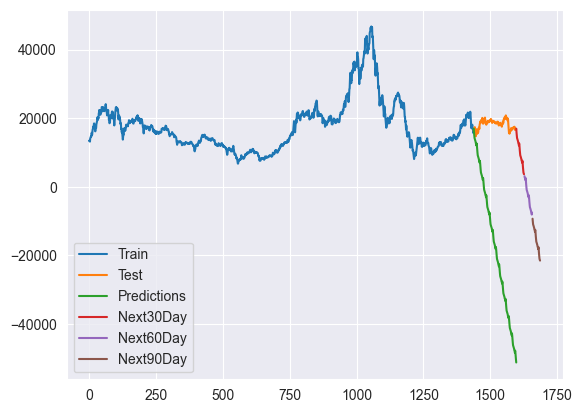

In [16]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [17]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        try:
            tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
                fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
            y_pred = tes_model.forecast(step)
            if np.isnan(y_pred).any():
                continue  # Skip this combination if y_pred contains NaN values
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        except ValueError as e:
            if "strictly positive" in str(e):
                continue  # Skip this combination if the error is due to non-positive values
            else:
                raise e

    return best_alpha, best_beta, best_gamma, best_mae





In [18]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='mul', seasonal_periods=12, step=160)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(160)

In [19]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([15689.8007764 , 15670.64209042, 15641.29896958, 15497.89499382,
       15282.89346592, 15262.56174003, 15454.4393598 , 15478.93755055,
       15367.05519658, 15382.75377791, 15211.7763685 , 15103.95686862,
       14994.05533501, 14975.74621803, 14947.70428277, 14810.65938472,
       14605.19184232, 14585.76170248, 14769.1307388 , 14792.54258659,
       14685.62152174, 14700.62396826, 14537.22834749, 14434.18997431,
       14329.1618927 , 14311.66467161, 14284.86622241, 14153.89841638,
       13957.54208629, 13938.97355275, 14114.21130857, 14136.58498598,
       14034.40520781, 14048.74238879, 13892.59235131, 13794.1230915 ,
       13693.7523545 , 13677.03102673, 13651.4209227 , 13526.26072732,
       13338.61158373, 13320.86644959, 13488.33349681, 13509.71504028,
       13412.0663021 , 13425.76771795, 13276.54196703, 13182.43920872,
       13086.51929195, 13070.53945146, 13046.06499685, 12926.45488056,
       12747.12681371, 12730.16856631, 12890.20948771, 12910.64289221,
      

In [20]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 6363.492889705658
RMSE: 6829.083479947537
MAPE: 0.345937021878033


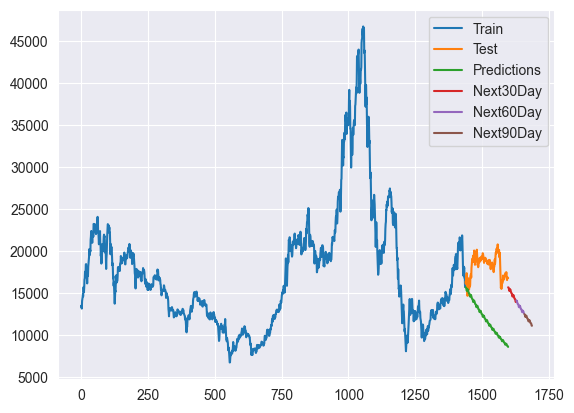

In [21]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [22]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='add', seasonal_periods=12, step=160)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(160)


In [23]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([15650.1830931 , 15617.75994249, 15618.47823668, 15499.12028483,
       15235.17060019, 15214.06635205, 15473.2139606 , 15604.02245068,
       15450.72694465, 15434.2502946 , 15227.19932445, 15107.15552739,
       14955.65298278, 14925.81375067, 14929.10635021, 14812.3131263 ,
       14550.91862783, 14532.36005959, 14794.04387713, 14927.37914052,
       14776.60100724, 14762.63236435, 14558.08007061, 14440.52565392,
       14291.50322824, 14264.13488806, 14269.88918686, 14155.54850376,
       13896.59742169, 13880.4731794 , 14144.58226628, 14280.33377607,
       14131.96289983, 14120.39255806, 13918.22964283, 13803.05571526,
       13656.40492235, 13631.39939157, 13639.5077092 , 13527.51228708,
       13270.89774072, 13257.10134134, 13523.52961065, 13661.59167463,
       13515.52275643, 13506.24580853, 13306.36775487, 13193.47018829,
       13049.08728745, 13026.34121131, 13036.70057754, 12926.94782926,
       12672.56761313, 12660.99723141, 12929.64323674, 13069.91478592,
      

In [24]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 6350.309796397977
RMSE: 6813.963748510719
MAPE: 0.3452493129854166


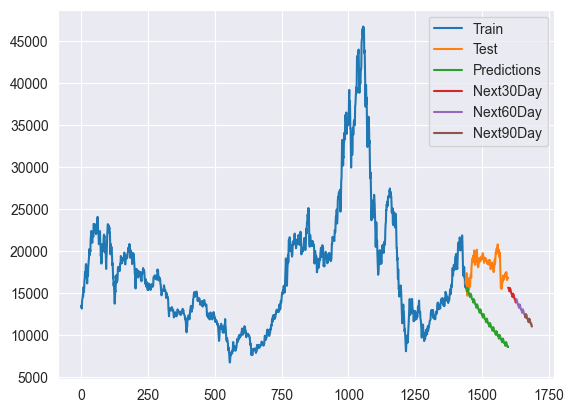

In [25]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [26]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='mul', seasonal_periods=12, step=160)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(160)


In [27]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([15667.56478256, 15626.48937009, 15573.74520976, 15407.72420705,
       15171.12329514, 15127.33335846, 15293.47954421, 15292.78567955,
       15156.99880572, 15146.47288074, 14952.11009416, 14820.01643516,
       14687.15481641, 14643.52391104, 14588.93520136, 14428.25114475,
       14201.554704  , 14155.38700176, 14305.56860579, 14299.57302675,
       14167.24829829, 14151.9981233 , 13964.9957208 , 13836.21023115,
       13706.74485026, 13660.55845198, 13604.12519296, 13448.77808246,
       13231.98611286, 13183.44064507, 13317.65766737, 13306.36037394,
       13177.49779086, 13157.52336586, 12977.88134743, 12852.40402714,
       12726.33488411, 12677.59299293, 12619.31518456, 12469.30502017,
       12262.41752172, 12211.49428837, 12329.74672894, 12313.14772113,
       12187.74728343, 12163.04860842, 11990.76697407, 11868.59782313,
       11745.92491796, 11694.62753387, 11634.50517616, 11489.83195787,
       11292.84893058, 11239.54793168, 11341.83579052, 11319.93506832,
      

In [28]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 8990.64489159838
RMSE: 9842.590155455513
MAPE: 0.49135974664279464


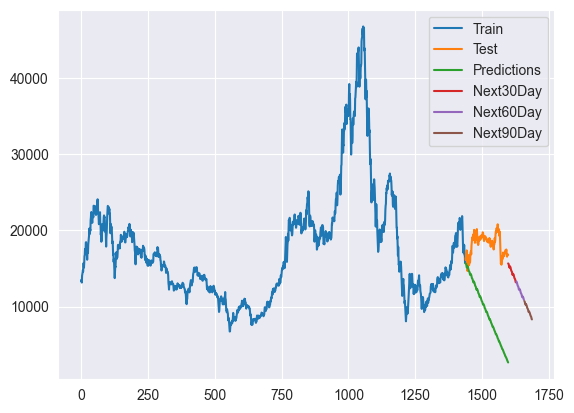

In [29]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

## Observation:
-  Triple Exponential Smoothing with both multiplicative trend and seasonality  acchieve the best MAE, RMSE, MAPE score  -> choose the model